For usage, clerar instructions I direct yiu to the startpage of the pyextremes library

https://georgebv.github.io/pyextremes/quickstart/

In [1]:
import os
import sys
sys.path.append('../Prelim_Stats')
import config
import numpy as np
import xarray as xr
import pyproj
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import probplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import multivariate_normal
from pyproj import Transformer
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes
from closest_grid_cell import select_nearest_grid_cell
from pyextremes import EVA


Precipitation 

In [76]:
data_hr_precip= xr.open_dataset(f'{config.TARGET_DIR}/RhiresD_1971_2023.nc') #Need to select 1981-2010 only
data_hr_precip= data_hr_precip.sel(time=slice('1981-01-01', '2010-12-31'))

In [77]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [78]:
data_hr_precip_locarno = select_nearest_grid_cell(data_hr_precip, target_lat, target_lon, 'RhiresD')
    
precip_series_hr = data_hr_precip_locarno['data']
lat_idx = data_hr_precip_locarno['lat_idx']
lon_idx = data_hr_precip_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14


In [79]:
#Pyextremes needs a pandas data series 
precip_series_hr_pd= precip_series_hr.to_pandas()

In [80]:
#Block maxima plotting
bm_hr_pr= get_extremes(precip_series_hr_pd, method='BM', block_size='365D')

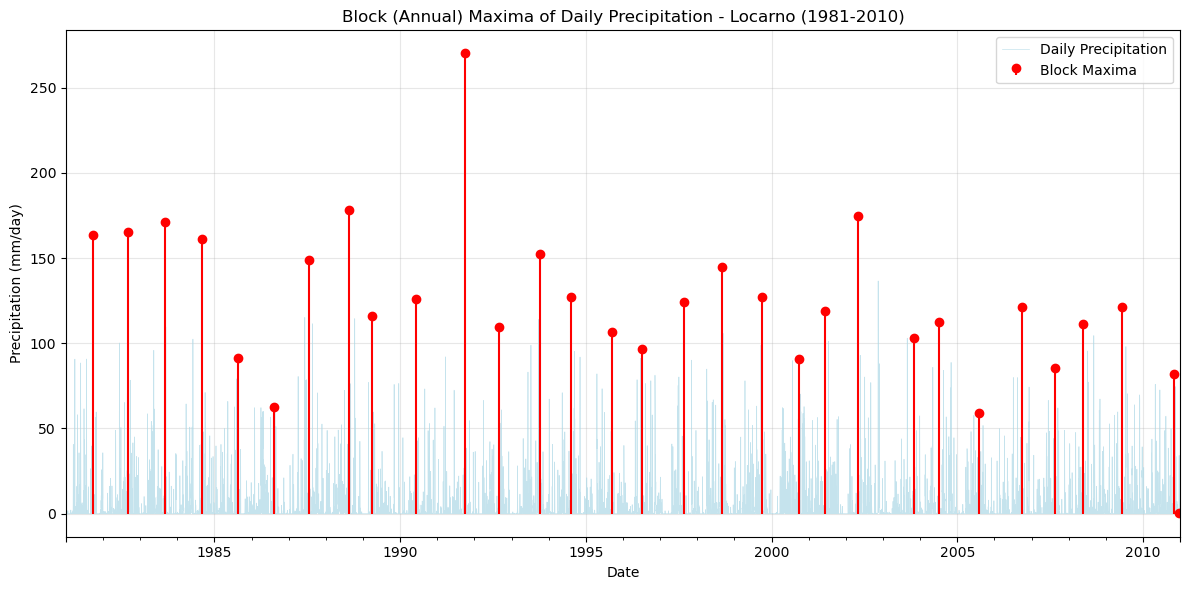

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))

precip_series_hr_pd.plot(ax=ax, color='lightblue', alpha=0.7, linewidth=0.5, label='Daily Precipitation')

ax.stem(bm_hr_pr.index, bm_hr_pr.values, linefmt='red', markerfmt='ro', basefmt='none', label='Block Maxima')

ax.set_title('Block (Annual) Maxima of Daily Precipitation - Locarno (1981-2010)')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Fitting GEV to block maxima of precipitation for Locarno

In [108]:
gev_precip_bm_model = EVA(precip_series_hr_pd)
extremes= gev_precip_bm_model.get_extremes(method="BM", block_size='365D')

In [109]:
gev_precip_bm_model.fit_model()

In [110]:
gev_precip_bm_model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                       RhiresD      Size:                              10,957
Start:                       January 1981      End:                        December 2010
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 31      Extraction method:                     BM
Type:                                high      Block size:             365 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Visualising fit quality for Locarno BM GEV


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='RhiresD'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='RhiresD', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

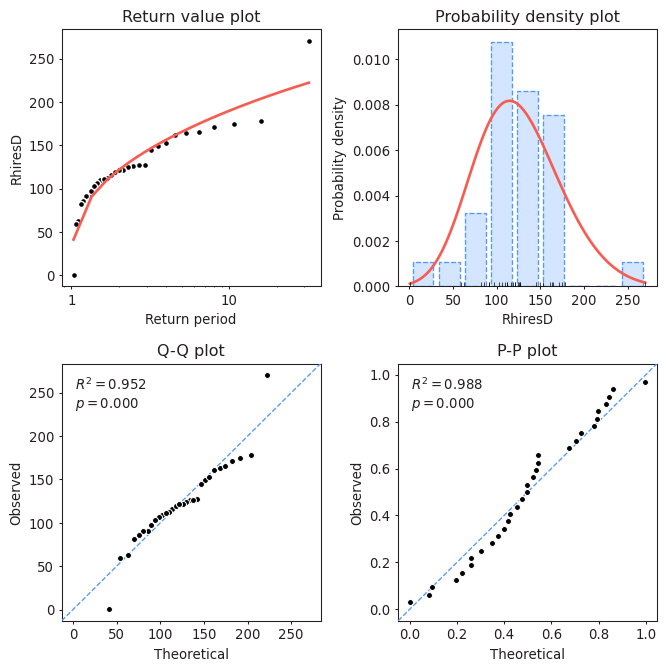

In [111]:
print("Visualising fit quality for Locarno BM GEV")
gev_precip_bm_model.plot_diagnostic()

#MODEL SUMMARY FOR RETURN PERIODS : 

In [112]:
gev_precip_bm_model_summary = gev_precip_bm_model.get_summary(
    return_period=[10,50, 100],
    alpha=0.95,
    n_samples=1000,
)

In [113]:
print(gev_precip_bm_model_summary)

               return value    lower ci      upper ci
return period                                        
10.0             189.687532  155.643797  4.566279e+06
50.0             232.550982  170.076648  3.510260e+11
100.0            247.060259  171.520056  4.082891e+13


Gettign entire return period table 

In [118]:
return_periods_precip_bm = get_return_periods(ts=precip_series_hr_pd,
                                              extremes= gev_precip_bm_model.extremes,
                                              extremes_method='BM', 
                                              extremes_type="high",
                                              block_size='365D',
                                              return_period_size="365D",
                                              plotting_position="median")

In [121]:
print(return_periods_precip_bm)

#Notes to self : 
#270 mm ,happened in 1991, return period is 45.years, only 2.2% chance of annual exceedance (in any given year)

               RhiresD  exceedance probability  return period
time                                                         
1981-09-21  163.689331                0.181173       5.519578
1982-09-06  165.055984                0.149291       6.698345
1983-09-01  171.397537                0.117408       8.517312
1984-09-05  161.464386                0.213056       4.693603
1985-08-25   91.145416                0.786944       1.270738
1986-08-11   62.737049                0.914475       1.093524
1987-07-17  149.143677                0.276821       3.612439
1988-08-20  178.496689                0.053643      18.641902
1989-04-04  115.949120                0.563765       1.773788
1990-06-05  126.030930                0.404352       2.473093
1991-09-26  270.141205                0.021760      45.956044
1992-08-29  109.446060                0.659413       1.516499
1993-10-08  152.504623                0.244939       4.082655
1994-08-10  127.072632                0.340587       2.936110
1995-09-

REPEATING SAME ANALYSIS FOR TEMPERATURE

Temperature

In [122]:
data_hr_temp= xr.open_dataset(f'{config.TARGET_DIR}/TabsD_1971_2023.nc')
data_hr_temp= data_hr_temp.sel(time=slice('1981-01-01', '2010-12-31'))

In [123]:
data_hr_temp_locarno = select_nearest_grid_cell(data_hr_temp, target_lat, target_lon, 'TabsD')

temp_series_hr = data_hr_temp_locarno['data']
lat_idx = data_hr_temp_locarno['lat_idx']
lon_idx = data_hr_temp_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'TabsD' extracted
Time series shape: (10957,)
Data range: -7.54 to 29.23


In [124]:
temp_series_hr_pd= temp_series_hr.to_pandas()

In [125]:
bm_hr_temp= get_extremes(temp_series_hr_pd, method='BM', block_size='365D')

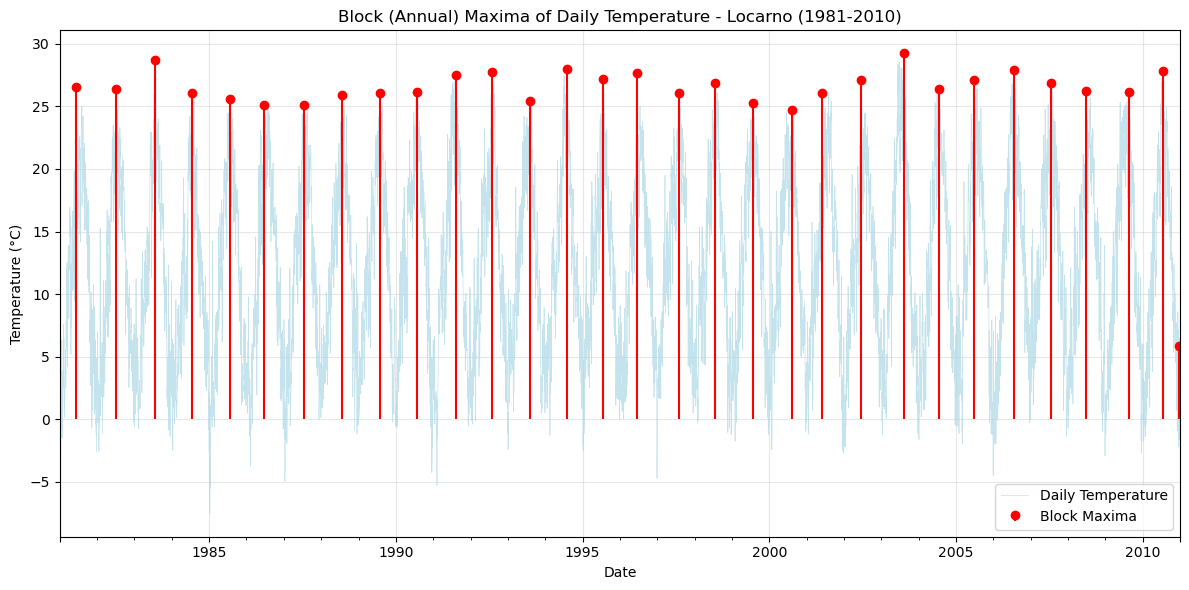

In [126]:
fig, ax = plt.subplots(figsize=(12, 6))

temp_series_hr_pd.plot(ax=ax, color='lightblue', alpha=0.7, linewidth=0.5, label='Daily Temperature')

ax.stem(bm_hr_temp.index, bm_hr_temp.values, linefmt='red', markerfmt='ro', basefmt='none', label='Block Maxima')

ax.set_title('Block (Annual) Maxima of Daily Temperature - Locarno (1981-2010)')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Fitting the model 

In [127]:
gev_temp_bm_model = EVA(temp_series_hr_pd)
extremes_temp= gev_temp_bm_model.get_extremes(method="BM", 
                               block_size='365D')

In [128]:
gev_temp_bm_model.fit_model()

In [129]:
gev_temp_bm_model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                         TabsD      Size:                              10,957
Start:                       January 1981      End:                        December 2010
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 31      Extraction method:                     BM
Type:                                high      Block size:             365 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Visualising fit quality for Locarno BM GE for temperature


(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='TabsD'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='TabsD', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

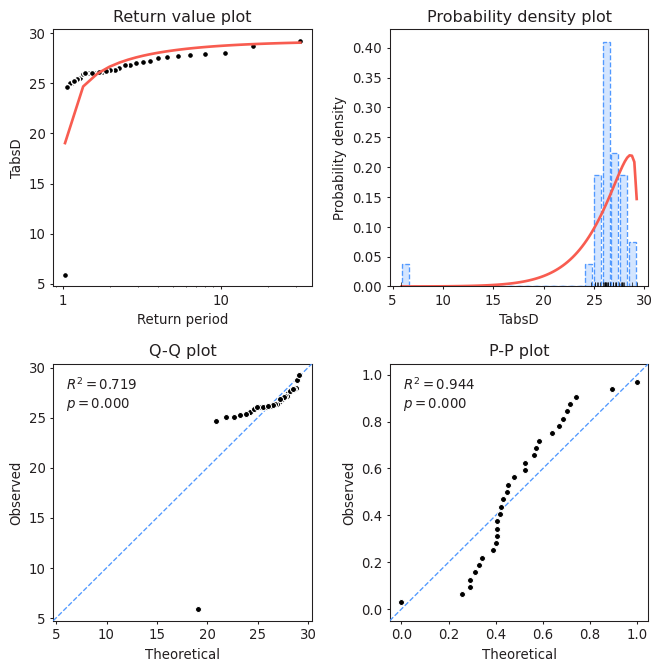

In [130]:
print("Visualising fit quality for Locarno BM GE for temperature")
gev_temp_bm_model.plot_diagnostic()

In [97]:
gev_temp_bm_model_summary = gev_temp_bm_model.get_summary(
    return_period=[10,50, 100],
    alpha=0.95,
    n_samples=1000,
)

In [98]:
print(gev_temp_bm_model_summary)

               return value   lower ci   upper ci
return period                                    
10.0              28.751276  27.566117  28.968371
50.0              29.131785  27.878847  29.859664
100.0             29.186310  27.889816  30.438020


In [134]:
return_periods_temp_bm = get_return_periods(ts=temp_series_hr_pd,
                                           extremes=bm_hr_temp,  
                                           extremes_method='BM', 
                                           extremes_type="high",
                                           block_size='365D',
                                           return_period_size="365D",
                                           plotting_position="median")

In [135]:
print(return_periods_temp_bm)

                TabsD  exceedance probability  return period
time                                                        
1981-06-13  26.561661                0.436235       2.292344
1982-07-07  26.378954                0.468117       2.136217
1983-07-21  28.718632                0.053643      18.641902
1984-07-14  26.045837                0.691296       1.446558
1985-07-26  25.552368                0.786944       1.270738
1986-06-23  25.076069                0.882592       1.133026
1987-07-14  25.072950                0.914475       1.093524
1988-07-23  25.905704                0.755061       1.324396
1989-07-26  26.025274                0.723179       1.382784
1990-07-23  26.169983                0.563765       1.773788
1991-08-10  27.499445                0.244939       4.082655
1992-07-28  27.745039                0.181173       5.519578
1993-08-06  25.413584                0.818827       1.221260
1994-08-05  28.006393                0.085525      11.692451
1995-07-23  27.212925   

xxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [5]:
from pyextremes import get_extremes, get_return_periods, EVA

In [6]:
from major_return_levels_bm import get_extreme_return_levels_bm

In [9]:
return_periods = [5, 10, 20, 50, 100]

obs_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.TARGET_DIR}/RhiresD_1971_2023.nc",
    variable_name="RhiresD",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

coarse_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.MODELS_DIR}/precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099/precip_r01_coarse_masked.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

eqm_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/precip_BC_bicubic_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

eqm_unet_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/DOWNSCALED_TRAINING_QM_BC_precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

dotc_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/precip_temp_tmin_tmax_bicubic_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

dotc_unet_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/DOWNSCALED_TRAINING_DOTC_BC_precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

qdm_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/precip_BC_bicubic_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

qdm_unet_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/DOWNSCALED_TRAINING_QDM_BC_precip_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="precip",
    lat=46.1709,
    lon=8.7995,
    return_periods=return_periods,
    block_size='365D',
    return_all_periods=False
)["return value"].values

baselines = {
    "COARSE": coarse_rl,
    "EQM": eqm_rl,
    "EQM_UNET": eqm_unet_rl,
    "DOTC": dotc_rl,
    "DOTC_UNET": dotc_unet_rl,
    "QDM": qdm_rl,
    "QDM_UNET": qdm_unet_rl
}

bias_table = pd.DataFrame(index=return_periods)
for name, rl in baselines.items():
    bias_table[name] = rl - obs_rl

print("Bias (Model - Obs) for each return period (Block Maxima) for daily precip for Locarno:")
print(bias_table)

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14
Target: (46.1709, 8.7995)
Closest grid cell: (46.1639, 8.8693)
Distance: 0.0701 degrees
Grid indices: lat_idx=4, lon_idx=21
Variable 'precip' extracted
Time series shape: (10957,)
Data range: -0.20 to 272.01
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'precip' extracted
Time series shape: (10957,)
Data range: -0.25 to 265.47
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'precip' extracted
Time series shape: (10957,)
Data range: 0.00 to 264.85
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'precip' extracted
Time ser

In [10]:
return_periods = [5, 10, 20, 50, 100]

# Get return levels for observations and each baseline
obs_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.TARGET_DIR}/TmaxD_1971_2023.nc",
    variable_name="TmaxD",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

coarse_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.MODELS_DIR}/tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099/tmax_r01_coarse_masked.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

eqm_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/tmax_BC_bicubic_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

eqm_unet_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/EQM/DOWNSCALED_TRAINING_QM_BC_tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

dotc_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/precip_temp_tmin_tmax_bicubic_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

dotc_unet_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/dOTC/DOWNSCALED_TRAINING_DOTC_BC_tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

qdm_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/tmax_BC_bicubic_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

qdm_unet_rl = get_extreme_return_levels_bm(
    nc_file=f"{config.BIAS_CORRECTED_DIR}/QDM/DOWNSCALED_TRAINING_QDM_BC_tmax_MPI-CSC-REMO2009_MPI-M-MPI-ESM-LR_rcp85_1971-2099_downscaled_gridset_r01.nc",
    variable_name="tmax",
    lat=46.1709,
    lon=8.7995,
    block_size='365D',
    return_periods=return_periods,
    return_all_periods=False
)["return value"].values

# Bias/error for each baseline
baselines = {
    "COARSE": coarse_rl,
    "EQM": eqm_rl,
    "EQM_UNET": eqm_unet_rl,
    "DOTC": dotc_rl,
    "DOTC_UNET": dotc_unet_rl,
    "QDM": qdm_rl,
    "QDM_UNET": qdm_unet_rl
}

bias_table = pd.DataFrame(index=return_periods)
for name, rl in baselines.items():
    bias_table[name] = rl - obs_rl

print("Bias (Model - Obs) for each return period (Block Maxima) for tmax for Locarno:")
print(bias_table)

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'TmaxD' extracted
Time series shape: (10957,)
Data range: -3.40 to 37.58
Target: (46.1709, 8.7995)
Closest grid cell: (46.1639, 8.8693)
Distance: 0.0701 degrees
Grid indices: lat_idx=4, lon_idx=21
Variable 'tmax' extracted
Time series shape: (10957,)
Data range: -12.70 to 31.79
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'tmax' extracted
Time series shape: (10957,)
Data range: -9.99 to 34.63
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'tmax' extracted
Time series shape: (10957,)
Data range: -6.41 to 37.75
Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'tmax' extracted
Time series shape: (